In [1]:
import numpy as np
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt

import multipletau

In [2]:
%pdb

Automatic pdb calling has been turned ON


In [3]:
def func_(x, T, c):
    return (( ((T-x)/(c*T**2)) * np.heaviside((T-x),0)) )

# Single track analysis

In [4]:
# read one file
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/1-ConfirmData/movie twiCrispr/"
file = "M142Het CJD1 ultrafast 0_10 in nc13 e1_Airyscan Processing/track_spot_table.csv"
f = path+file
datas = pd.read_csv(f) 
datas.drop(index=[0,1,2], inplace=True)
datas['FRAME'] = pd.to_numeric(datas["FRAME"])
datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])

In [5]:
print(np.unique(datas.TRACK_ID))
datas.head()

[  4  12 108]


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,VISIBILITY,MANUAL_SPOT_COLOR,MEAN_INTENSITY_CH1,MEDIAN_INTENSITY_CH1,MIN_INTENSITY_CH1,MAX_INTENSITY_CH1,TOTAL_INTENSITY_CH1,STD_INTENSITY_CH1,CONTRAST_CH1,SNR_CH1
3,ID16896,16896,4,640.8803100585938,14.672849,2.816024,0.0,51.758672,103,0.27675532062103897,1,NaN,919.000000,713.0,278.0,3227.0,19299.0,636.5629583945331,0.2513738267762486,0.5800122059339992
4,ID17921,17921,4,456.7908020019531,17.063794,4.065223,0.0,100.502276,200,0.27675532062103897,1,NaN,725.238095,600.0,251.0,2185.0,15230.0,509.96077346810756,0.3119838047961062,0.6763592115546067
5,ID17410,17410,4,949.4459838867188,16.042649,2.971747,0.0,75.879219,151,0.27675532062103897,1,NaN,921.523810,729.0,412.0,1797.0,19352.0,451.3130420282156,0.30399919140190695,0.9520368938059725
6,ID18434,18434,4,568.4943237304688,17.398563,3.704569,0.0,117.085152,233,0.27675532062103897,1,NaN,697.333333,490.0,271.0,2258.0,14644.0,512.3118516424672,0.30594045057799285,0.6377486474863099
7,ID16387,16387,4,783.6535034179688,13.932617,4.801880,0.0,29.145660,58,0.27675532062103897,1,NaN,994.904762,647.0,400.0,2859.0,20893.0,677.574712099109,0.3237241423005037,0.7181776989750908


12


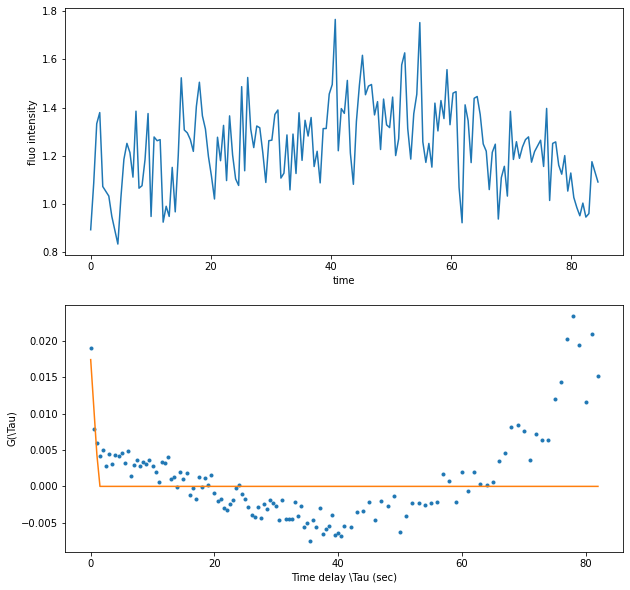

In [6]:
# Analyse one track
# Choose your track id
id_= np.unique(datas.TRACK_ID)[1]
# id_ = 0
print(id_)

x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values/2**16*100
fig, ax = plt.subplots(2,1)
ax[0].plot(x,y)
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")

mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
if (mm%2)==0: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm,
                                    deltat=0.5, 
                                    normalize=True)
else: 
    autocor = multipletau.autocorrelate(y,
                                    m=mm+1,
                                    deltat=0.5,
                                    normalize=True)



popt, pcov = optimize.curve_fit(func_, 
                            autocor.flatten()[0::2],
                            autocor.flatten()[1::2], 
                            method='lm' )


ax[1].plot(autocor.flatten()[0::2], autocor.flatten()[1::2], '.')
ax[1].plot(autocor.flatten()[0::2], func_(autocor.flatten()[0::2], *popt) )
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

fig.set_size_inches((10,10))

# Multiple file analysis

In [138]:
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/1-ConfirmData/movie twiCrispr/"
# path = "/mnt/sda1/Sophie/2-KineticAnalysisData/1-ConfirmData/movie fast ilp4/"
files = [
    "M142Het CJD1 ultrafast 0_20 in nc14 e1_Airyscan Processing_track.csv",
    "M142Het CJD1 ultrafast 0_20 in nc14 e2_Airyscan Processing_track.csv",
        ]

# path = "/mnt/sda1/Sophie/2-KineticAnalysisData/1-ConfirmData/movie fast ilp4/"
# files = [
#          "scfvhet ilp4 laser 5percent zoom8 time frame754.2ms__Airyscan Processing_nc14/track_spot_table.csv",
#         ]

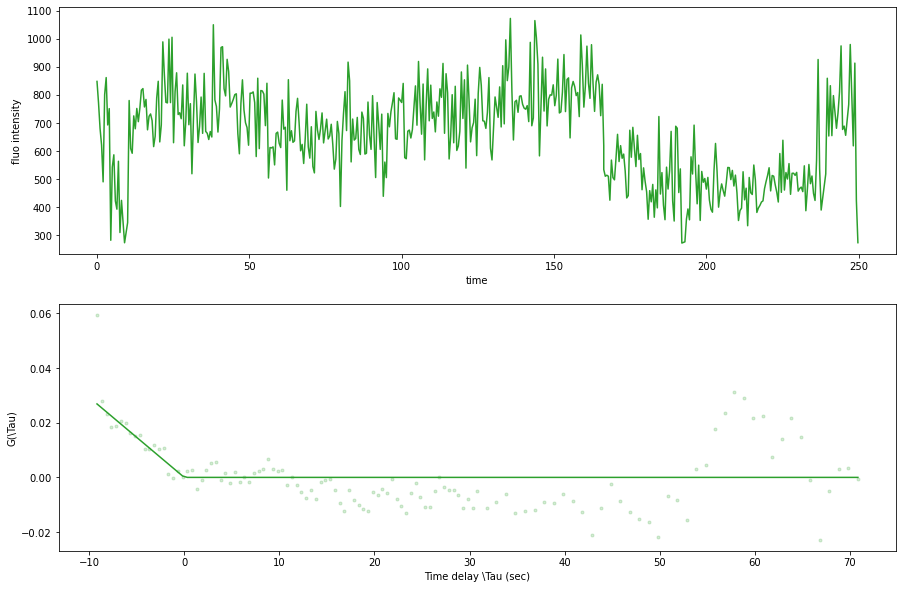

In [139]:
columns = ['file_name', 'track_id','len_track', 'elongation_time', 'init_translation_rate']
result = pd.DataFrame(columns=columns, dtype=float)
elongation_time=[]
translation_rate=[]
# xx = []
# yy = []
cpt = 0
for f in files:
    f = path+f
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    datas.drop("MANUAL_SPOT_COLOR", axis=1, inplace=True)
    datas = datas.dropna(axis=0)
    


    for id_ in np.unique(datas['TRACK_ID']):
        
        x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
        y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values
#         if cpt != 0:
#             x = xx[-1]+x
           
#         cpt += 1
#         xx.extend(x)
#         yy.extend(y)
        if len(x)>10:
            mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
            if (mm%2)==0: 
                autocor = multipletau.autocorrelate(y,
                                                m=mm,
                                                deltat=0.5, 
                                                normalize=True)
            else: 
                autocor = multipletau.autocorrelate(y,
                                                m=mm+1,
                                                deltat=0.5,
                                                normalize=True)


    
            popt, pcov = optimize.curve_fit(func_, 
                                        autocor.flatten()[0::2][1:],
                                        autocor.flatten()[1::2][1:], 
                                        method='lm' )
            if popt[0]>5: #5
#                 if len(x)*0.5>100:
                    d = pd.DataFrame.from_dict({'file_name':f.split('/')[-2],
                                                'track_id':id_,
                                                'len_track': len(x)*0.5,
                                                'elongation_time':popt[0],
                                                'init_translation_rate':popt[1]},
                                               orient='index').T
                    result = pd.concat([result, d], ignore_index=True)
        
        
# mm = int(xx[-1]/2-1)
# print(mm)
# if (mm%2)==0: 
#     autocor = multipletau.autocorrelate(yy,
#                                     m=mm,
#                                     deltat=0.5, 
#                                     normalize=True)
# else: 
#     autocor = multipletau.autocorrelate(yy,
#                                     m=mm+1,
#                                     deltat=0.5,
#                                     normalize=True)



# popt, pcov = optimize.curve_fit(func_, 
#                             autocor.flatten()[0::2],
#                             autocor.flatten()[1::2], 
#                             method='lm' )
# print(popt)
# print(1485/popt)

fig, ax = plt.subplots(2,1)
ax[0].plot(xx, yy, color=colors[i])

ax[1].plot(autocor.flatten()[0::2]-popt[0], autocor.flatten()[1::2], '.', color=colors[i], alpha = 0.2)
ax[1].plot(autocor.flatten()[0::2]-popt[0], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
# ax[1].set_ylim(-0.05, 0.05)

fig.set_size_inches((15,10))

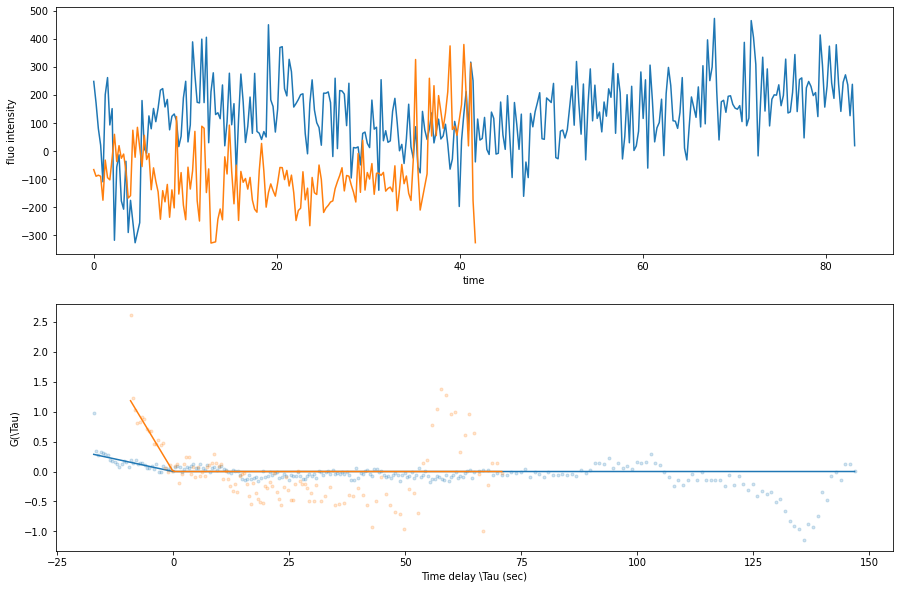

In [136]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(2,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
for f in files:
    f = path+f
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    datas.drop("MANUAL_SPOT_COLOR", axis=1, inplace=True)
    datas = datas.dropna(axis=0)
    


    for id_ in np.unique(datas['TRACK_ID']):

        x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
        y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values-600

        

        mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
        if (mm%2)==0: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm,
                                            deltat=0.5, 
                                            normalize=True,
                                               )
        else: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm+1,
                                            deltat=0.5,
                                            normalize=True,
                                               )



        popt, pcov = optimize.curve_fit(f=func_, 
                                        xdata=autocor.flatten()[0::2][1:],
                                        ydata=autocor.flatten()[1::2][1:],
                                        method='lm')

#         print(popt)
#         print(1485/popt)
        if popt[0]>5:
                ax[0].plot(x*0.5, y, color=colors[i])

                ax[1].plot(autocor.flatten()[0::2]-popt[0], autocor.flatten()[1::2], '.', color=colors[i], alpha = 0.2)
                ax[1].plot(autocor.flatten()[0::2]-popt[0], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
        if i == 7:
            i=0
        else:
            i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
# ax[1].set_ylim(-0.05, 0.05)

fig.set_size_inches((15,10))

In [140]:
result['elongation_time_norm'] = 1485/result['elongation_time']
result['init_translation_rate_norm'] = result['init_translation_rate']
result['tmp'] = 1

In [141]:
result

,file_name,track_id,len_track,elongation_time,init_translation_rate,elongation_time_norm,init_translation_rate_norm,tmp
0,movie twiCrispr,20,165.0,17.100922,6.555416,86.837423,6.555416,1
1,movie twiCrispr,69,81.0,9.173256,4.054952,161.883628,4.054952,1


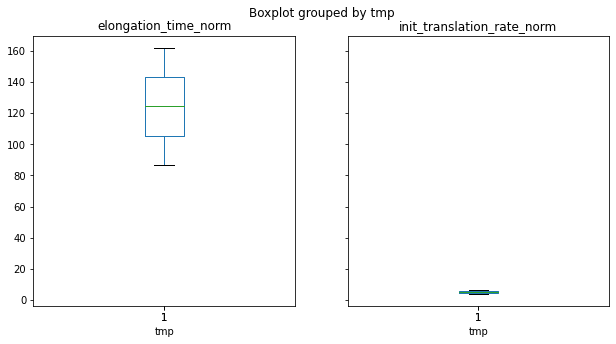

In [142]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = result.boxplot(['elongation_time_norm', 'init_translation_rate_norm'] , 
#                          by='file_name', 
                         by='tmp',
                         grid=False, 
                         figsize=(10,5))


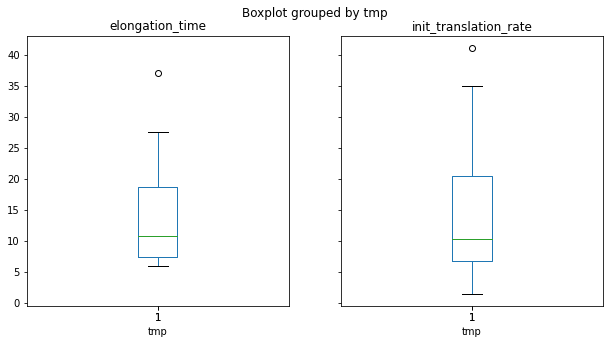

In [132]:
# result['elongation_time'] = pd.to_numeric(result['elongation_time'])
fig, ax = result.boxplot(['elongation_time', 'init_translation_rate'] , 
#                          by='file_name', 
                         by='tmp', 
                         grid=False, 
                         figsize=(10,5))


In [133]:
result.mean()

/tmp/ipykernel_32116/2046019998.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  result.mean()


track_id                      464.437500
len_track                      92.125000
elongation_time                13.876441
init_translation_rate          14.718507
elongation_time_norm          143.907302
init_translation_rate_norm     14.718507
tmp                             1.000000
dtype: float64

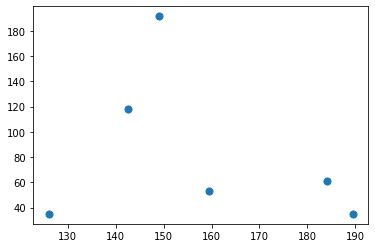

In [15]:
plt.scatter(result['len_track'], result['elongation_time_norm'], s=50)

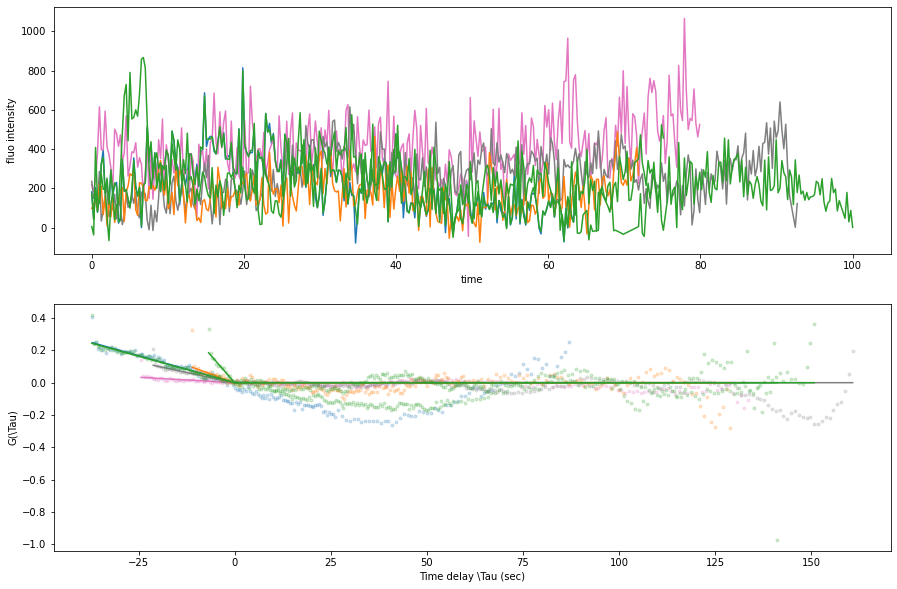

In [57]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(2,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
for f in files:
    f = path+f
    datas = pd.read_csv(f)
    datas.drop(index=[0,1,2], inplace=True)
    datas['FRAME'] = pd.to_numeric(datas["FRAME"])
    datas['POSITION_X'] = pd.to_numeric(datas["POSITION_X"])
    datas['POSITION_Y'] = pd.to_numeric(datas["POSITION_Y"])
    datas['TRACK_ID'] = pd.to_numeric(datas["TRACK_ID"])
    datas['MEAN_INTENSITY_CH1'] = pd.to_numeric(datas["MEAN_INTENSITY_CH1"])
    datas['POSITION_T'] = pd.to_numeric(datas["POSITION_T"])
    datas.drop("MANUAL_SPOT_COLOR", axis=1, inplace=True)
    datas = datas.dropna(axis=0)
    


    for id_ in np.unique(datas['TRACK_ID']):

        x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
        y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values-600

        

        mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
        if (mm%2)==0: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm,
                                            deltat=0.5, 
                                            normalize=True,
                                               )
        else: 
            autocor = multipletau.autocorrelate(y,
                                            m=mm+1,
                                            deltat=0.5,
                                            normalize=True,
                                               )



        popt, pcov = optimize.curve_fit(f=func_, 
                                        xdata=autocor.flatten()[0::2][1:],
                                        ydata=autocor.flatten()[1::2][1:],
                                        method='lm')

#         print(popt)
#         print(1485/popt)
        if popt[0]>5:
            if len(x)*0.5>100:
                ax[0].plot(x*0.5, y, color=colors[i])

                ax[1].plot(autocor.flatten()[0::2]-popt[0], autocor.flatten()[1::2], '.', color=colors[i], alpha = 0.2)
                ax[1].plot(autocor.flatten()[0::2]-popt[0], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
        if i == 7:
            i=0
        else:
            i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")
# ax[1].set_ylim(-0.05, 0.05)

fig.set_size_inches((15,10))

# plot all track that was keep in result table

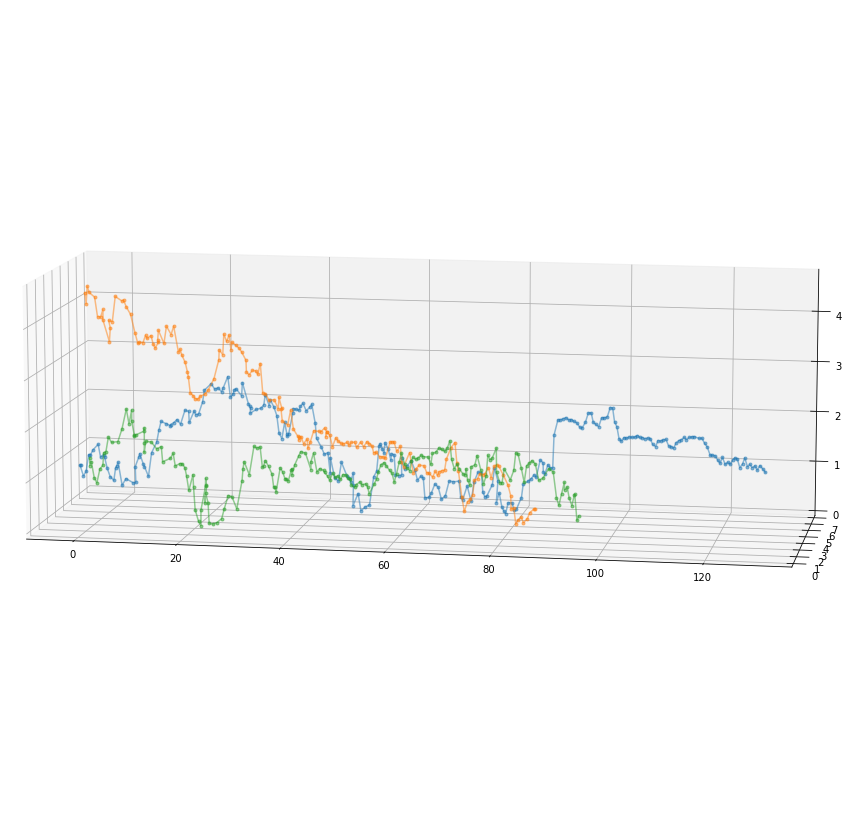

In [585]:
from mpl_toolkits.mplot3d.axes3d import Axes3D
fig = plt.figure()
ax = plt.axes(projection='3d')

# ax.get_proj = lambda: np.dot(Axes3D.get_proj(ax), np.diag([1, 0.5, 0.5, 1]))
ax.set_box_aspect(aspect = (3,1,1))


for id_ in np.unique(result['track_id']):
    x = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].to_numpy()))
    y = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_X'].to_numpy()))
    z = (datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()
         - np.min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_Y'].to_numpy()))
    
    ax.plot(x, 
            y, 
            z, 
            '.-',
            alpha = 0.5
            )


fig.set_size_inches((15, 15))

ax.view_init(elev=10., azim=-80)

125
[36.99989114  1.46508914]
[  40.13525322 1013.59020436]
82
[17.79892294 10.0542773 ]
[ 83.4320147  147.69833334]
93
[27.49989746  6.33738   ]
[ 54.00020135 234.32396349]


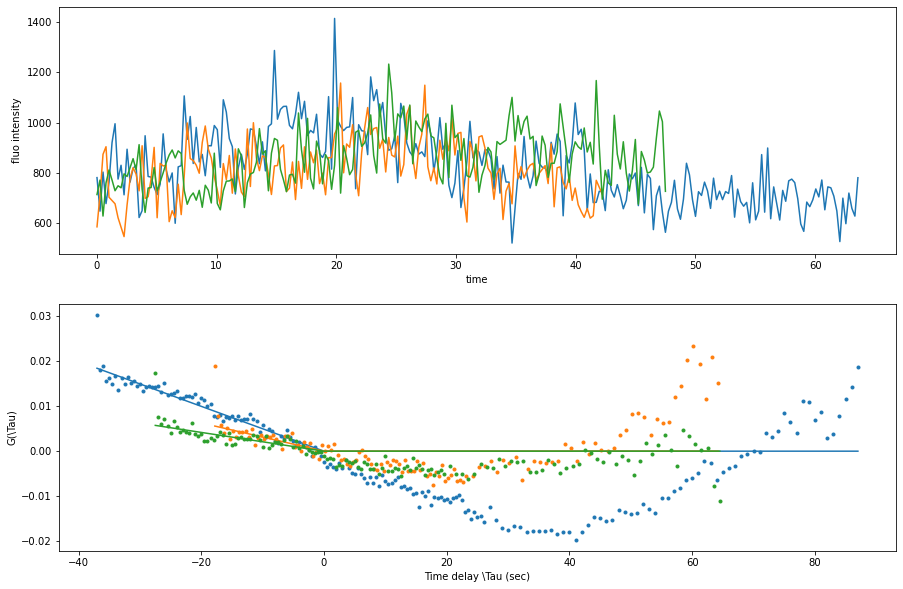

In [38]:
import matplotlib.colors as mcolors
fig, ax = plt.subplots(2,1)

colors = list(mcolors.TABLEAU_COLORS.keys())

i=0
for id_ in np.unique(result['track_id'].to_numpy()):

    x = datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values-min(datas[datas.TRACK_ID==id_].sort_values('FRAME')['POSITION_T'].values)
    y = datas[datas.TRACK_ID==id_].sort_values('FRAME')['MEAN_INTENSITY_CH1'].values
    
    ax[0].plot(x*0.5, y, color=colors[i])


    mm = int(len(datas[datas.TRACK_ID==id_])/2-1)
    print(mm)
    if (mm%2)==0: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm,
                                        deltat=0.5, 
                                        normalize=True,
                                           )
    else: 
        autocor = multipletau.autocorrelate(y,
                                        m=mm+1,
                                        deltat=0.5,
                                        normalize=True,
                                           )



    popt, pcov = optimize.curve_fit(f=func_, 
                                    xdata=autocor.flatten()[0::2][1:],
                                    ydata=autocor.flatten()[1::2][1:],
                                    method='lm')

    print(popt)
    print(1485/popt)
    ax[1].plot(autocor.flatten()[0::2]-popt[0], autocor.flatten()[1::2], '.', color=colors[i])
    ax[1].plot(autocor.flatten()[0::2]-popt[0], func_(autocor.flatten()[0::2], *popt), color=colors[i] )
    if i == 7:
        i=0
    else:
        i+=1

ax[0].set_xlabel("time")
ax[0].set_ylabel("fluo intensity")
ax[1].set_xlabel("Time delay \Tau (sec)")
ax[1].set_ylabel("G(\Tau)")

fig.set_size_inches((15,10))

In [591]:
result

,file_name,track_id,len_track,elongation_time,init_translation_rate,elongation_time_norm,init_translation_rate_norm,tmp
0,M142Het CJD1 ultrafast 0_10 in nc13 e1_Airysca...,4,126.0,36.999891,1.465089,40.135253,1.465089,1
1,M142Het CJD1 ultrafast 0_10 in nc13 e1_Airysca...,12,83.5,17.798923,10.054277,83.432015,10.054277,1
2,M142Het CJD1 ultrafast 0_10 in nc13 e1_Airysca...,108,94.0,27.499897,6.33738,54.000201,6.33738,1


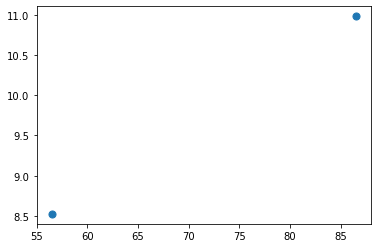

In [411]:
plt.scatter(result['len_track'], result['elongation_time'], s=50)